<div style="text-align: center;">
  <h2><strong></strong></h2>
</div>

<center>

## **Prueba Técnica Novaventa**
## **Sistema de Recomendaciones: Filtrado de Colaborativo Basado en Items**

**Autor:** Sebastian Carvalho Salazar  

</center>

## Librerias

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import IncrementalPCA
from scipy import sparse
import time
import numpy as np

## Rutas

In [19]:
import yaml
import os

# Obtener la ruta absoluta del archivo paths.yaml
current_dir = current_dir = os.getcwd()
config_path = os.path.join(current_dir, '..', 'Config', 'paths.yaml')

# Cargar el contenido del archivo YAML
with open(config_path, 'r') as file:
    paths = yaml.safe_load(file)

## Datos

In [20]:
path_1 = paths['StagingZone']['dataset_1']
dataset_1 = pd.read_csv(path_1, sep=";").drop(['Unnamed: 0'], axis=1)

path_2 = paths['StagingZone']['productos']
productos = pd.read_csv(path_2, sep=";").drop(['Unnamed: 0'], axis=1)

path_3 = paths['StagingZone']['user_item_matrix']
user_item_matrix = pd.read_parquet(path_3)

## Transformación

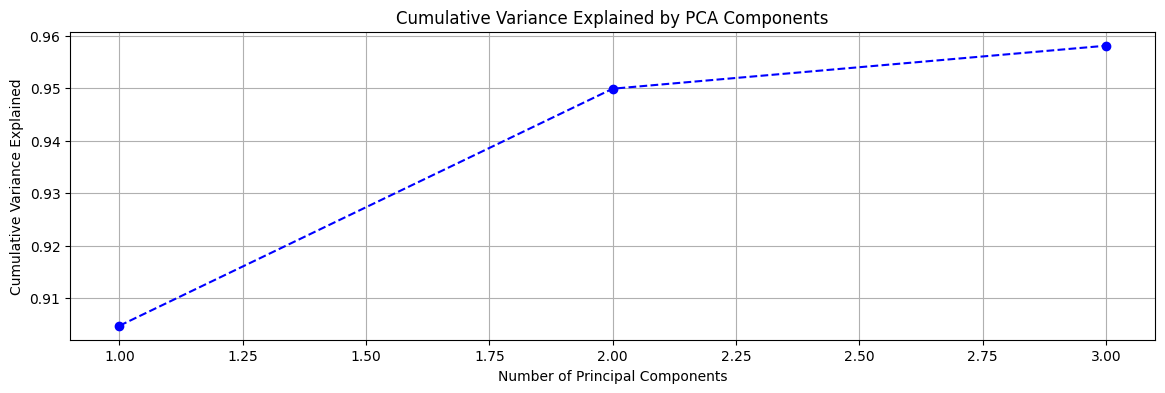

In [21]:
sparse_user_item_matrix = sparse.csr_matrix(user_item_matrix.T)

# Aplicar IncrementalPCA
n_components = 3    # Número de componentes principales que queremos retener
batch_size = 1000   # Tamaño de los bloques
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
reduced_matrix = ipca.fit_transform(sparse_user_item_matrix)

# Calcular la varianza explicada acumulativa
cumulative_variance = ipca.explained_variance_ratio_.cumsum()

# Graficar la varianza acumulativa
plt.figure(figsize=(14, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid()
plt.show()

pd.DataFrame(reduced_matrix, index=user_item_matrix.T.index).to_csv(paths['TrustZone']['PCA_IBCF'], sep=";")

In [22]:
user_item_matrix_reduced = pd.read_csv(paths['TrustZone']['PCA_IBCF'], sep=";")
user_item_matrix_reduced = user_item_matrix_reduced.set_index(['COD_PRODUCTO'])

In [23]:
item_similarity_matrix = cosine_similarity(sparse.csr_matrix(user_item_matrix_reduced))
pd.DataFrame(item_similarity_matrix, index=user_item_matrix.columns, columns=user_item_matrix.columns).to_parquet(paths['TrustZone']['CS_IBCF'])

## Modelo

In [30]:
%run models.ipynb

In [31]:
path_4 = paths['TrustZone']['CS_IBCF']
item_similarity_matrix = pd.read_parquet(path_4)

In [32]:
user_id = user_item_matrix.sample(1).index[0]
top_k_items, recommendations = recommend_products_ibcf(user_id, user_item_matrix, item_similarity_matrix)

print("Productos valorados por el usuario:", top_k_items,"\n")
print("Productos recomendados:", recommendations,"\n")

print(f"Recommended products for user_id: {productos[productos['COD_PRODUCTO'].isin(top_k_items)]['CATEGORIA'].values}","\n")
print(f"Recommended products for user_id: {productos[productos['COD_PRODUCTO'].isin(recommendations)]['CATEGORIA'].values}","\n")

Productos valorados por el usuario: Index([ 3065,  6567,  6569, 21358, 28355, 28409, 28418, 28903, 28941, 28944,
       29059, 29081, 29154, 31019, 31167, 31194, 32645, 32791, 33105, 33114,
       33118, 33135, 33136, 33745, 33754, 34464, 94041, 94477, 94493, 94758,
       97017, 97019, 97027, 97492],
      dtype='int64', name='COD_PRODUCTO') 

Productos recomendados: [88, 4410, 70] 

Recommended products for user_id: ['Sal, Salsas, Aderezos Y Especias' 'Galletas' 'Aseo Del Hogar'
 'Aseo Del Hogar' 'Fitoterapeuticos' 'Snacks Y Frutos Secos'
 'Desodorantes' 'Galletas' 'Aseo Del Hogar' 'Snacks Y Frutos Secos'
 'Galletas' 'Aseo Del Hogar' 'Vitaminas, Minerales Y Suplementos' 'Quesos'
 'Aseo Del Hogar' 'Snacks Y Frutos Secos' 'Aceites' 'Cuidado Capilar P'
 'Snacks Y Frutos Secos' 'Snacks Y Frutos Secos' 'Aseo Del Hogar'
 'Granos y Cereales' 'Aseo Del Hogar' 'Snacks Y Frutos Secos'
 'Alimentos Larga Vida Y Conservas' 'Snacks Y Frutos Secos' 'Aromaterapia'
 'Hogar' 'Sal, Salsas, Aderezos Y E

In [34]:
dataset_1[dataset_1['UUID_CLIENTE_CONSUMIDOR']==user_id]

,UUID_CLIENTE_CONSUMIDOR,PEDIDO,FECHA_SOLUCION,COD_PRODUCTO,CATEGORIA,UNIDADES_BRUTAS,VENTA_BRUTA_CON_IVA,FREQUENCIA_COMPRA
9278,731A4A8E794D281E100A180327615250,36618707,2023-01-15,32791,Hogar,1,62990.0,1
11551,731A4A8E794D281E100A180327615250,37985029,2023-05-14,28418,Cuidado Capilar P,1,29750.0,1
21149,731A4A8E794D281E100A180327615250,36618707,2023-01-15,28409,Aseo Del Hogar,2,103800.0,1
25667,731A4A8E794D281E100A180327615250,36618707,2023-01-15,31019,Snacks Y Frutos Secos,1,10950.0,1
30171,731A4A8E794D281E100A180327615250,39145018,2023-08-26,6569,Snacks Y Frutos Secos,1,15500.0,1
30369,731A4A8E794D281E100A180327615250,36618707,2023-01-15,28941,Aseo Del Hogar,1,10400.0,1
41628,731A4A8E794D281E100A180327615250,39145018,2023-08-26,34464,Aseo Del Hogar,2,52000.0,1
44555,731A4A8E794D281E100A180327615250,36618707,2023-01-15,31194,Granos y Cereales,2,24000.0,1
54100,731A4A8E794D281E100A180327615250,37985029,2023-05-14,94758,"Sal, Salsas, Aderezos Y Especias",1,22912.0,1
61023,731A4A8E794D281E100A180327615250,36618707,2023-01-15,97027,Aromaterapia,1,21150.0,1


## Rendimiento

In [35]:
def measure_execution_time():
    start_time = time.time()
    
    user_id = user_item_matrix.sample(1).index[0]
    top_k_items, recommendations = recommend_products_ibcf(user_id, user_item_matrix, item_similarity_matrix)
    
    end_time = time.time()
    return end_time - start_time

execution_times = []

for _ in range(100):
    execution_time = measure_execution_time()
    execution_times.append(execution_time)

average_time = np.mean(execution_times)
std_time = np.std(execution_times)

print(f"Average execution time over 100 runs: {average_time} ± {std_time} seconds")

Average execution time over 100 runs: 1.7008693051338195 ± 2.1652435426345846 seconds


# FIN
---